In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ra_glorich_df = pd.read_csv('RiverAtlas_GLORICH_colocated_for_prediction.csv')
# Get rid of variables that are droppped from traininig set during workflow.
# Add the two derived variables that are added during preprocessing stage of
# ML workflow (see ./scripts/prep_06_merge.py)
ra_glorich_df.pop('Sample_ID')
ra_glorich_df.pop('Sample_Longitude')
ra_glorich_df.pop('Sample_Latitude')
ra_glorich_df.pop('my_lm')
ra_glorich_df.pop('RA_lon')
ra_glorich_df.pop('RA_lat')
ra_glorich_df.pop('STAT_ID')
ra_glorich_df.pop('TOC')
ra_glorich_df.pop('dist_m')
ra_glorich_df['RA_ms_av'] = ra_glorich_df['RA_cms_cyr']/ra_glorich_df['RA_xam2']
ra_glorich_df['RA_ms_di'] = (ra_glorich_df['RA_cms_cmx'] - ra_glorich_df['RA_cms_cmn'])/ra_glorich_df['RA_xam2']

# This file is good for in situ variables, but does not have RA data colocated to it.
#s19s_sss_df = pd.read_csv('WHONDRS_S19S_SSS_merged.csv', index_col='Sample_ID')

# Grab the training set from an active ML model branch
repo_prefix = '~/tmp/'
repo_name = 'sl-archive-whondrs'
repo_url = 'https://github.com/parallelworks/'+repo_name
branch = 'S19S-SSS-log10-extrap-r01'

# Grab the data and get onto the branch if not already there
! mkdir -p {repo_prefix}
! cd {repo_prefix}; git clone {repo_url}
! cd {repo_prefix}/{repo_name}; git checkout {branch}
s19s_sss_df = pd.read_csv(repo_prefix+repo_name+'/scripts/prep_06_output_final_train.csv')

columns = ["pH", "Mean_Temp_Deg_C", "Mean_DO_mg_per_L", "Mean_DO_percent_saturation"]

fatal: destination path 'sl-archive-whondrs' already exists and is not an empty directory.
Already on 'S19S-SSS-log10-extrap-r01'


## Look at data values

- maximum value of `Mean_Temp_Deg_C` in `ra_glorich_df` is 87 deg C, which means there's probably an error somewhere
- `Mean_DO_percent_saturation` is funky
  - min values in each dataset are different by 27.611000
  - max values are 161.900000 and 217.274000, both of which seem high for a value that's a percentage
  - range of `Mean_DO_percent_saturation` for `ra_glorich_df` is ~204
  - range of `Mean_DO_percent_saturation` for `s19s_sss_df` is ~121
- `Mean_DO_mg_per_L` for both datasets has a very low min value: 1.570000 and 3.830000 
- min `pH` value for `ra_glorich_df` is 3.62, which is more acidic than acid rain

In [3]:
ra_glorich_df[columns].describe()

,pH,Mean_Temp_Deg_C,Mean_DO_mg_per_L,Mean_DO_percent_saturation
count,10437.000000,10521.000000,2987.000000,5724.000000
mean,7.503957,16.001805,9.973386,95.489699
std,0.724420,6.206808,1.515635,15.462948
min,3.620000,-0.400000,1.570000,13.489000
25%,7.060000,11.450000,9.242150,88.921917
50%,7.678261,15.220000,10.200000,97.000000
75%,8.050000,20.400000,10.875000,102.746457
max,10.410000,87.000000,16.475000,217.274000


In [4]:
s19s_sss_df[columns].describe()

,pH,Mean_Temp_Deg_C,Mean_DO_mg_per_L,Mean_DO_percent_saturation
count,367.000000,364.000000,274.000000,274.000000
mean,7.317330,18.085879,8.701960,91.312190
std,0.664089,5.691339,1.892032,18.348226
min,6.000000,4.500000,3.830000,41.100000
25%,6.700000,13.860000,7.990000,85.400000
50%,7.500000,17.860000,8.970000,92.060000
75%,7.820000,21.685000,9.719939,100.040000
max,8.830000,33.400000,13.310000,161.900000


In [5]:
# difference between the descriptions
ra_glorich_df[columns].describe() - s19s_sss_df[columns].describe()

,pH,Mean_Temp_Deg_C,Mean_DO_mg_per_L,Mean_DO_percent_saturation
count,10070.000000,10157.000000,2713.000000,5450.000000
mean,0.186627,-2.084074,1.271427,4.177510
std,0.060330,0.515469,-0.376397,-2.885278
min,-2.380000,-4.900000,-2.260000,-27.611000
25%,0.360000,-2.410000,1.252150,3.521917
50%,0.178261,-2.640000,1.230000,4.940000
75%,0.230000,-1.285000,1.155061,2.706457
max,1.580000,53.600000,3.165000,55.374000


### visualise `describe()`

the descriptions of the two datasets look fairly similar when plotted

<Axes: >

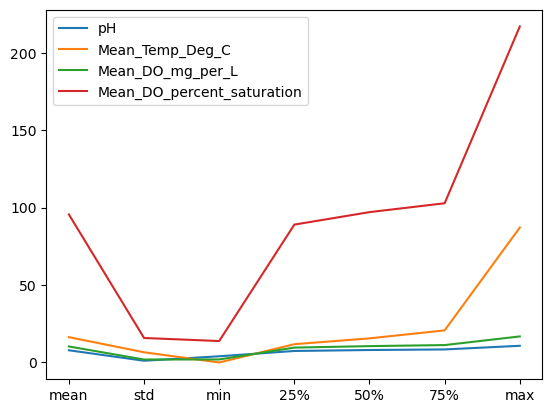

In [6]:
ra_glorich_df[columns].describe().drop(["count"]).plot()

<Axes: >

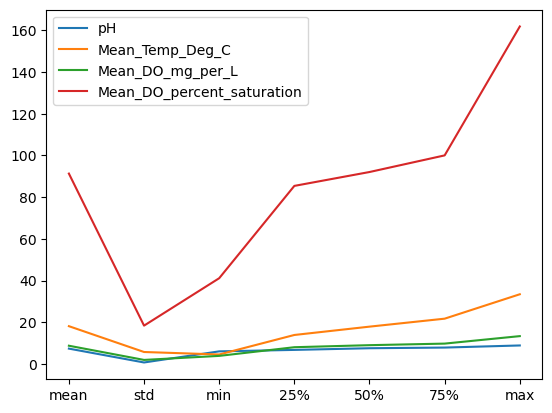

In [7]:
s19s_sss_df[columns].describe().drop(["count"]).plot()

view the descriptions on the same graph

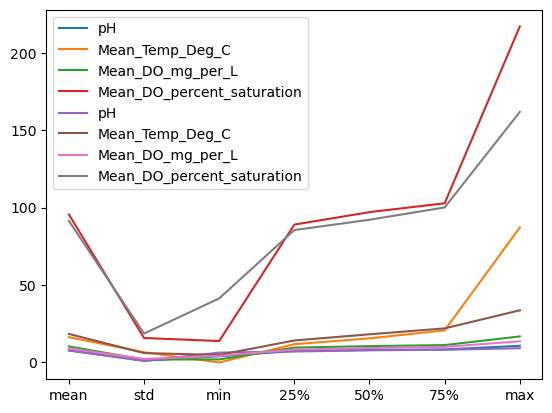

In [8]:
ax = ra_glorich_df[columns].describe().drop(["count"]).plot()
s19s_sss_df[columns].describe().drop(["count"]).plot(ax=ax)

plt.show()

## missing/nan values 

- `ra_glorich_df` has 42.998808% more missing `Mean_DO_mg_per_L` values than `s19s_sss_df`
- `ra_glorich_df` has 20.253926% more missing `Mean_DO_percent_saturation` values than `s19s_sss_df`

In [9]:
# total missing values
ra_glorich_df[columns].isnull().sum()

pH                              84
Mean_Temp_Deg_C                  0
Mean_DO_mg_per_L              7534
Mean_DO_percent_saturation    4797
dtype: int64

In [10]:
# total missing values
s19s_sss_df[columns].isnull().sum()

pH                             0
Mean_Temp_Deg_C                3
Mean_DO_mg_per_L              93
Mean_DO_percent_saturation    93
dtype: int64

In [11]:
# percentage missing values
ra_glorich_df[columns].isnull().mean() * 100

pH                             0.798403
Mean_Temp_Deg_C                0.000000
Mean_DO_mg_per_L              71.609163
Mean_DO_percent_saturation    45.594525
dtype: float64

In [12]:
# percentage missing values
s19s_sss_df[columns].isnull().mean() * 100

pH                             0.000000
Mean_Temp_Deg_C                0.817439
Mean_DO_mg_per_L              25.340599
Mean_DO_percent_saturation    25.340599
dtype: float64

In [13]:
# difference in percentage of missing valuse
(ra_glorich_df[columns].isnull().mean() - s19s_sss_df[columns].isnull().mean()) * 100

pH                             0.798403
Mean_Temp_Deg_C               -0.817439
Mean_DO_mg_per_L              46.268563
Mean_DO_percent_saturation    20.253926
dtype: float64

## What are the distributions of these two different variables?

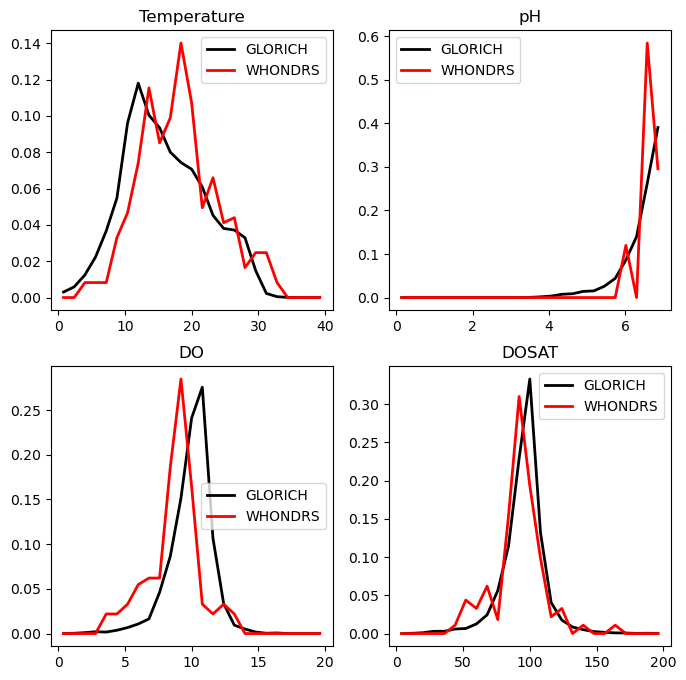

In [14]:
# Set up figure panels
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(8,8))

#====================================
ax1.set_title('Temperature')
#====================================

# Key definitions for histograms
# Number of histogram bins and range for consistent histograms
num_bins = 25
min_bin = 0.0
max_bin = 40.0

# Compute counts
counts, bins = np.histogram(
    ra_glorich_df["Mean_Temp_Deg_C"], bins=num_bins, range=(min_bin,max_bin))
    
# Plot histogram; find center of each bin, divide number of counts in each bin by total number of counts => probability
ax1.plot(
    (bins[:-1]+bins[1:])/2,
    counts/np.sum(counts),
    linestyle=('solid'), color='k', linewidth=2)

# Compute counts
counts, bins = np.histogram(
    s19s_sss_df["Mean_Temp_Deg_C"], bins=num_bins, range=(min_bin,max_bin))
    
# Plot histogram; find center of each bin, divide number of counts in each bin by total number of counts => probability
ax1.plot(
    (bins[:-1]+bins[1:])/2,
    counts/np.sum(counts),
    linestyle=('solid'), color='r', linewidth=2)

ax1.legend(['GLORICH','WHONDRS'])

#====================================
ax2.set_title('pH')
#====================================

# Key definitions for histograms
# Number of histogram bins and range for consistent histograms
num_bins = 25
min_bin = 0.0
max_bin = 7.0

# Compute counts
counts, bins = np.histogram(
    ra_glorich_df["pH"], bins=num_bins, range=(min_bin,max_bin))
    
# Plot histogram; find center of each bin, divide number of counts in each bin by total number of counts => probability
ax2.plot(
    (bins[:-1]+bins[1:])/2,
    counts/np.sum(counts),
    linestyle=('solid'), color='k', linewidth=2)

# Compute counts
counts, bins = np.histogram(
    s19s_sss_df["pH"], bins=num_bins, range=(min_bin,max_bin))
    
# Plot histogram; find center of each bin, divide number of counts in each bin by total number of counts => probability
ax2.plot(
    (bins[:-1]+bins[1:])/2,
    counts/np.sum(counts),
    linestyle=('solid'), color='r', linewidth=2)

ax2.legend(['GLORICH','WHONDRS'])

#====================================
ax3.set_title('DO')
#====================================

# Key definitions for histograms
# Number of histogram bins and range for consistent histograms
num_bins = 25
min_bin = 0.0
max_bin = 20.0

# Compute counts
counts, bins = np.histogram(
    ra_glorich_df["Mean_DO_mg_per_L"], bins=num_bins, range=(min_bin,max_bin))
    
# Plot histogram; find center of each bin, divide number of counts in each bin by total number of counts => probability
ax3.plot(
    (bins[:-1]+bins[1:])/2,
    counts/np.sum(counts),
    linestyle=('solid'), color='k', linewidth=2)

# Compute counts
counts, bins = np.histogram(
    s19s_sss_df["Mean_DO_mg_per_L"], bins=num_bins, range=(min_bin,max_bin))
    
# Plot histogram; find center of each bin, divide number of counts in each bin by total number of counts => probability
ax3.plot(
    (bins[:-1]+bins[1:])/2,
    counts/np.sum(counts),
    linestyle=('solid'), color='r', linewidth=2)

ax3.legend(['GLORICH','WHONDRS'])

#====================================
ax4.set_title('DOSAT')
#====================================

# Key definitions for histograms
# Number of histogram bins and range for consistent histograms
num_bins = 25
min_bin = 0.0
max_bin = 200.0

# Compute counts
counts, bins = np.histogram(
    ra_glorich_df["Mean_DO_percent_saturation"], bins=num_bins, range=(min_bin,max_bin))
    
# Plot histogram; find center of each bin, divide number of counts in each bin by total number of counts => probability
ax4.plot(
    (bins[:-1]+bins[1:])/2,
    counts/np.sum(counts),
    linestyle=('solid'), color='k', linewidth=2)

# Compute counts
counts, bins = np.histogram(
    s19s_sss_df["Mean_DO_percent_saturation"], bins=num_bins, range=(min_bin,max_bin))
    
# Plot histogram; find center of each bin, divide number of counts in each bin by total number of counts => probability
ax4.plot(
    (bins[:-1]+bins[1:])/2,
    counts/np.sum(counts),
    linestyle=('solid'), color='r', linewidth=2)

ax4.legend(['GLORICH','WHONDRS'])

Observations:
1. GLORICH is colder than WHONDRS -> makes sense because S19S and SSS campaigns are in summer while GLORICH data can be any season (but I don't know the actual seasonal distribution; there may be a bais towards warmer months).
2. I don't think there is a pH bias.
3. WHONDRS has lower Oxygen than GLORICH. This is broadly consistent with the potential seasonal bias in #1, above because less oxygen can be dissolved in warmer water.

## What are the rough observed relationships between respiration rate and the in situ chemistry data?
If there is a significant relationship between temp|pH|DO|DOSAT and respiration rate and if the models have learned these trends, then the baises in histograms above should be related to the final bais in predicted respiration rates.

Text(0.5, 0, 'Mean_DO_percent_saturation')

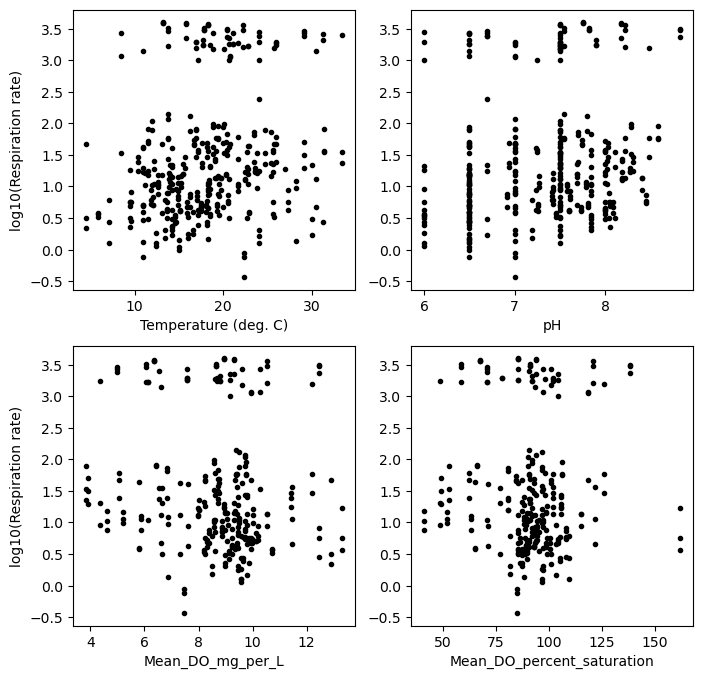

In [15]:
# Set up figure panels
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(8,8))

#====================================

ax1.plot(
    s19s_sss_df['Mean_Temp_Deg_C'],
    np.log10(np.abs(s19s_sss_df['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])),
    'k.')
ax1.set_xlabel('Temperature (deg. C)')
ax1.set_ylabel('log10(Respiration rate)')
#ax1.set_ylim([3.0,3.5])

#====================================

ax2.plot(
    s19s_sss_df['pH'],
    np.log10(np.abs(s19s_sss_df['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])),
    'k.')
ax2.set_xlabel('pH')
#ax2.set_ylabel('log10(Respiration rate)')
#ax2.set_ylim([3.0,3.5])

#====================================
    
ax3.plot(
    s19s_sss_df['Mean_DO_mg_per_L'],
    np.log10(np.abs(s19s_sss_df['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])),
    'k.')
ax3.set_xlabel('Mean_DO_mg_per_L')
ax3.set_ylabel('log10(Respiration rate)')
#ax3.set_ylim([3.0,3.5])

#====================================
    
ax4.plot(
    s19s_sss_df['Mean_DO_percent_saturation'],
    np.log10(np.abs(s19s_sss_df['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])),
    'k.')
ax4.set_xlabel('Mean_DO_percent_saturation')
#ax4.set_ylabel('log10(Respiration rate)')
#ax4.set_ylim([3.0,3.5])

Observations:
1. There may be very very very weak relationships and those relationships could even be potentially different (**NONLINEAR**) depending on whether a site is a weak or strong respiration rate.  For example, for the weaker respiration rate sites (bottom part of top left panel), it appears (squinting eyes) that higher T results in stronger respiration rate. On the other hand, for sites in the upper part of the plot (top left panel), higher temp may result in weaker respiration rate.
2. However, the gap between respiration rates is still really clear and there does not appear to be any pattern where any of the in-situ observed variables "bring" respiration rates that much closer or farter from jumping across the weak-strong respiration rate gap.

Let's rerun the predictions for just GLORICH-RA but after changing the mean value of temp, pH, DO, and DOSAT to match WHONDRS' mean values. There could be a strong non-linear effect in the ML models that amplifies the relatively small, probably seasonal bias, in GLORICH relative to WHONDRS. Here, we find the differences in the mean values of the WHONDRS and GLORICH data.

In [16]:
print('WH T - GL T = '+str(s19s_sss_df['Mean_Temp_Deg_C'].mean() - ra_glorich_df['Mean_Temp_Deg_C'].mean()))
print('WH pH - GL pH = '+str(s19s_sss_df['pH'].mean() - ra_glorich_df['pH'].mean()))
print('WH DO - GL DO = '+str(s19s_sss_df['Mean_DO_mg_per_L'].mean() - ra_glorich_df['Mean_DO_mg_per_L'].mean()))
print('WH DOSAT - GL DOSAT = '+str(s19s_sss_df['Mean_DO_percent_saturation'].mean() - ra_glorich_df['Mean_DO_percent_saturation'].mean()))

WH T - GL T = 2.08407431976158
WH pH - GL pH = -0.18662680695643363
WH DO - GL DO = -1.2714265937552973
WH DOSAT - GL DOSAT = -4.177509541392979


## What are the systematic differences between WHONDRS and GLORICH across ALL features (not just the in situ ones)?
It could be that small systematic differences between these data sets are amplified.

In [17]:
# Drop the targets since we need both DF to have the same number of columns
s19s_sss_df.pop('Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment')

0     -2236.81
1     -3827.24
2     -3800.03
3        -5.81
4        -5.53
        ...   
362      -3.73
363     -46.77
364   -1185.05
365   -1138.30
366     -47.16
Name: Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment, Length: 367, dtype: float64

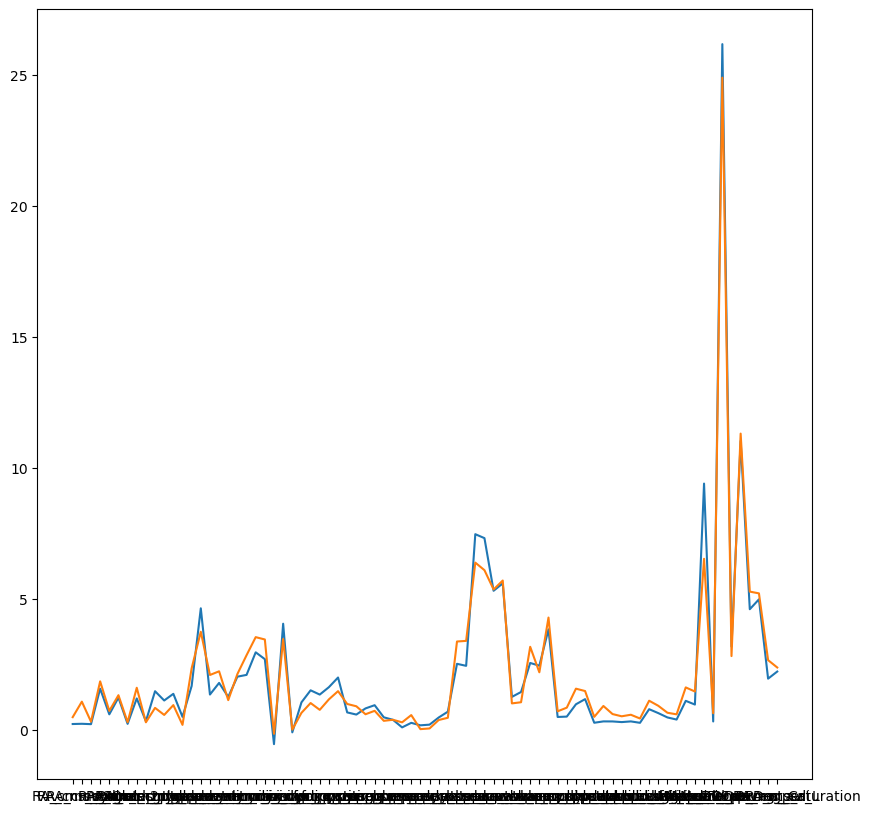

In [18]:
# Lets compare all the input features
fig, ax = plt.subplots(1,1,figsize=(10,10))

# They should be normalized by the same std,
# not by their respective std.
ax.plot(s19s_sss_df.mean()/s19s_sss_df.std())
ax.plot(ra_glorich_df.mean()/s19s_sss_df.std())

In [19]:
# So there are deviations.  Print out the values that differ by more than 2 in plot above
# to show the significant ones.
# Since we have:
# m +/- s
# mean = mean, s = std
# Divide both sides by std,
# m/s +/- 1
# this is one std envelope. The two envelopes do not overlap if there is a difference of more than 2.

list = np.abs(s19s_sss_df.mean()/s19s_sss_df.std() - ra_glorich_df.mean()/s19s_sss_df.std())
list[list > 1]


slt_pc_cav    1.084787
slt_pc_uav    1.222119
gdp_md_cav    2.869632
hdi_ix_cav    1.278821
dtype: float64